In [1]:
## Import libs
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import TransformerMixin
import csv
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
SEED=42

## God Class Evaluation

In [3]:
data = pd.read_csv('gc.csv', dtype={col: np.float32 for col in ['lcc', 'lcom*']})
data.dropna(inplace=True)
data.head()

,dit,fanin,fanout,lcc,lcom*,loc,noc,rfc,icq,nof,nom,wmc,gc
0,4,1,6,0.0,0.592593,39,0,12,0,3,9,10,0
1,4,2,7,0.0,0.000000,18,0,6,0,0,4,6,0
2,1,0,0,0.0,1.000000,56,0,0,3,4,4,4,0
3,1,1,0,0.0,0.000000,4,0,0,0,0,2,2,0
4,3,3,5,0.0,0.000000,16,0,7,0,0,4,4,0


In [4]:
X = data.drop(['gc'], axis=1)
y = data.gc

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

### Decision Tree Evaluation

#### Only original features

In [6]:
feature_names = ['dit','fanin','fanout','lcc','lcom*','loc','noc','rfc','icq','nof','nom','wmc']

features = np.arange(1, 13, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

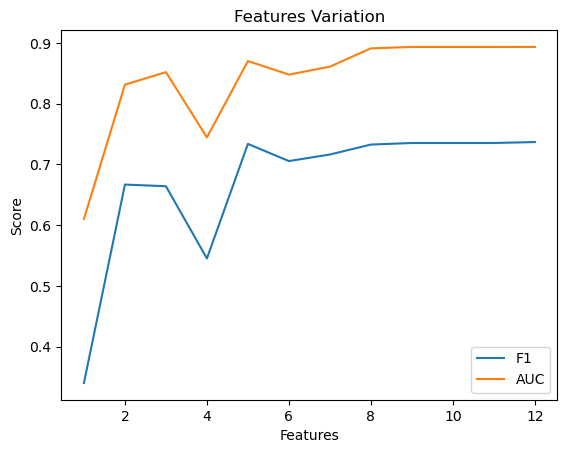

In [10]:
# Plotando o gráfico
plt.plot(features, f1, label='F1')
plt.plot(features, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [17]:
features_set = []
for i, features in enumerate(selected_features):
    features_set.append('|'.join(features))

In [18]:
# Export results
nome_arquivo = "gc_fv.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Polynomial Features

In [28]:
feature_names = ['dit','fanin','fanout','lcc','lcom*','loc','noc','rfc','icq','nof','nom','wmc']

features = np.arange(1, 13, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

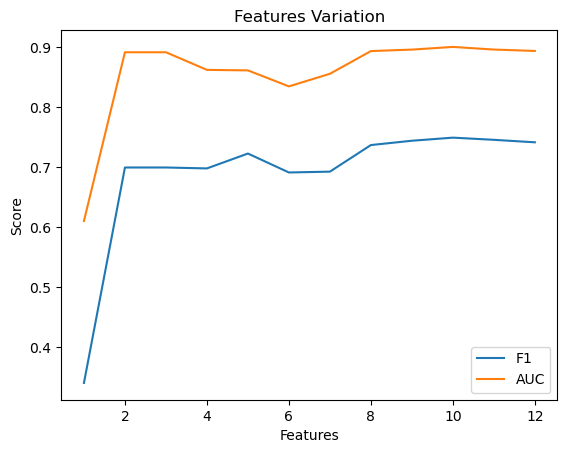

In [29]:
# Plotando o gráfico
plt.plot(features, f1, label='F1')
plt.plot(features, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [30]:
features_set = []
for i, features in enumerate(selected_features):
    features_set.append('|'.join(features))

In [31]:
# Export results
nome_arquivo = "gc_fv_poly.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Oversample variation

In [6]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        smote = SMOTE(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        #('feature_selection', SelectKBest(score_func=f_classif, k=2)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

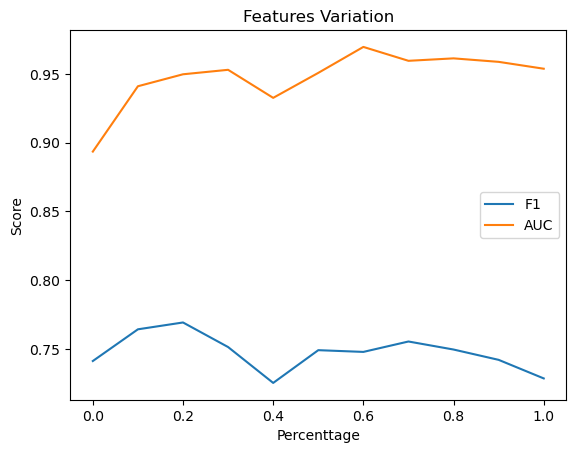

In [7]:
# Plotando o gráfico
plt.plot(percentage_samples, f1, label='F1')
plt.plot(percentage_samples, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Percenttage')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [8]:
# Export results
nome_arquivo = "gc_oversample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

#### Undersample variation

In [9]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        undersample = RandomUnderSampler(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = undersample.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=2)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

C:\Users\henri\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\henri\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\henri\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\henri\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\henri\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\henri\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarn

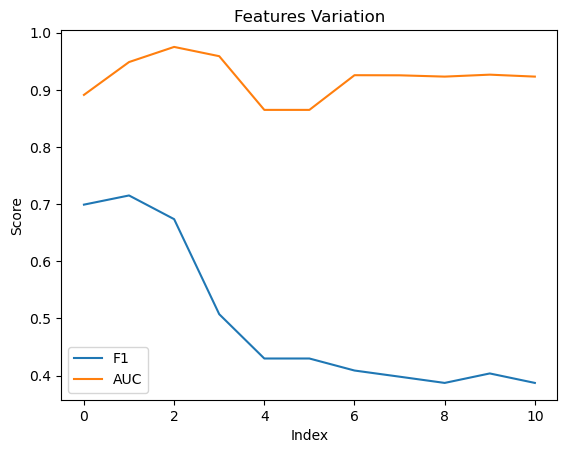

In [10]:
indices = range(len(f1))

# Plotando o gráfico
plt.plot(indices, f1, label='F1')
plt.plot(indices, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [11]:
# Export results
nome_arquivo = "gc_undersample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

## Refused Bequest Evaluation

In [3]:
data = pd.read_csv('rb.csv', dtype={col: np.float32 for col in ['lcc', 'lcom*']})
data.dropna(inplace=True)
data.head()

,dit,fanin,fanout,lcc,lcom*,loc,noc,rfc,icq,nof,nom,wmc,rb
0,4,1,6,0.0,0.592593,39,0,12,0,3,9,10,0
1,4,2,7,0.0,0.000000,18,0,6,0,0,4,6,0
2,1,0,0,0.0,1.000000,56,0,0,3,4,4,4,0
3,1,1,0,0.0,0.000000,4,0,0,0,0,2,2,0
4,3,3,5,0.0,0.000000,16,0,7,0,0,4,4,0


In [4]:
X = data.drop(['rb'], axis=1)
y = data.rb

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

### Decision Tree Evaluation

#### Original features variation

In [6]:
feature_names = ['dit','fanin','fanout','lcc','lcom*','loc','noc','rfc','icq','nof','nom','wmc']

features = np.arange(1, 13, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

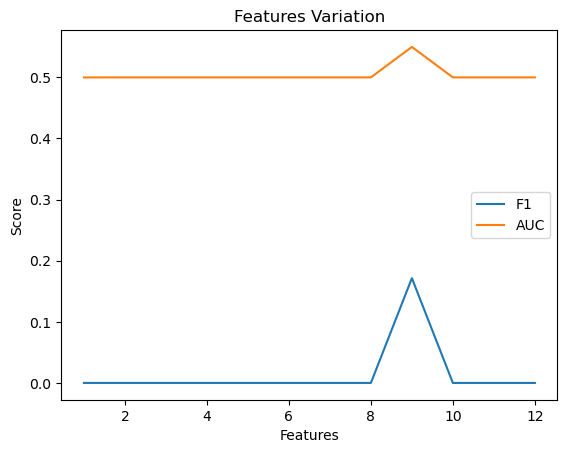

In [7]:
# Plotando o gráfico
plt.plot(features, f1, label='F1')
plt.plot(features, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [8]:
features_set = []
for i, features in enumerate(selected_features):
    features_set.append('|'.join(features))

In [10]:
# Export results
nome_arquivo = "rb_fv.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Polynomial features variation

In [11]:
feature_names = ['dit','fanin','fanout','lcc','lcom*','loc','noc','rfc','icq','nof','nom','wmc']

features = np.arange(1, 13, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

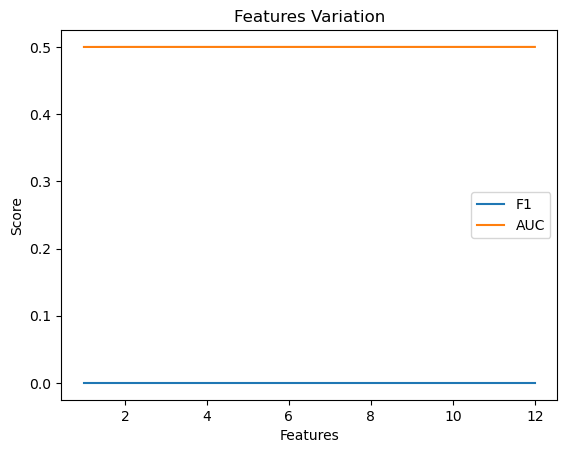

In [12]:
# Plotando o gráfico
plt.plot(features, f1, label='F1')
plt.plot(features, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [13]:
features_set = []
for i, features in enumerate(selected_features):
    features_set.append('|'.join(features))

In [14]:
# Export results
nome_arquivo = "rb_fv_poly.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Oversample variation

In [15]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        smote = SMOTE(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        #('feature_selection', SelectKBest(score_func=f_classif, k=2)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

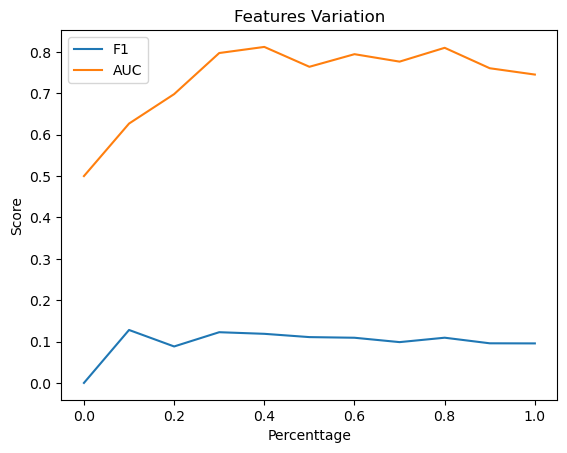

In [16]:
# Plotando o gráfico
plt.plot(percentage_samples, f1, label='F1')
plt.plot(percentage_samples, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Percenttage')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [17]:
# Export results
nome_arquivo = "rb_oversample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

#### Undersample variation

In [19]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        undersample = RandomUnderSampler(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = undersample.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', DecisionTreeClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': list(range(1, 11)),
        'classifier__min_samples_split': list(range(2, 21)),
        'classifier__min_samples_leaf': list(range(1, 11)),
        'classifier__max_features': ['sqrt', 'log2', None],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

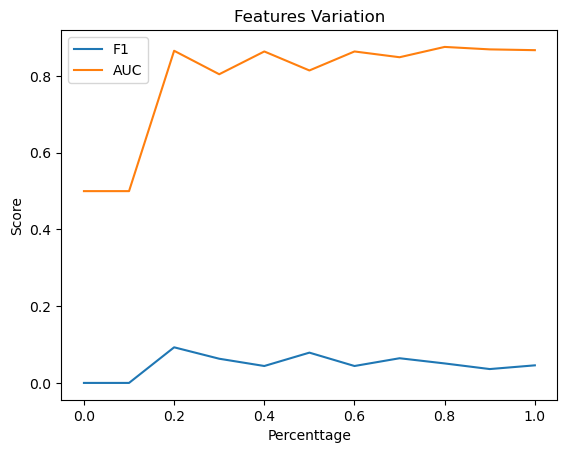

In [20]:
# Plotando o gráfico
plt.plot(percentage_samples, f1, label='F1')
plt.plot(percentage_samples, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Percenttage')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [21]:
# Export results
nome_arquivo = "rb_undersample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

## Long Method Evaluation

### Gradient Boosting Machine

In [22]:
data = pd.read_csv('lm.csv')
data.dropna(inplace=True)
data.head()

,fanin,fanout,wmc,loc,rq,vq,pq,lq,cq,icq,lm
0,0,1,1,3,0,0,1,0,0,0,0
1,0,1,1,3,0,0,1,0,0,0,0
2,0,1,1,3,0,0,1,0,0,0,0
3,0,1,2,8,0,0,1,0,0,0,0
4,0,0,1,3,1,0,0,0,0,0,0


In [23]:
X = data.drop(['lm'], axis=1)
y = data.lm

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

#### Only original features

In [25]:
feature_names = ['fanin','fanout','wmc','loc','rq','vq','pq','lq','cq','icq']

features = np.arange(1, 11, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('classifier', GradientBoostingClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__n_estimators': [10, 100, 1000],
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__subsample': [0.5, 0.7, 1.0],
        'classifier__max_depth': [3, 7, 9],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

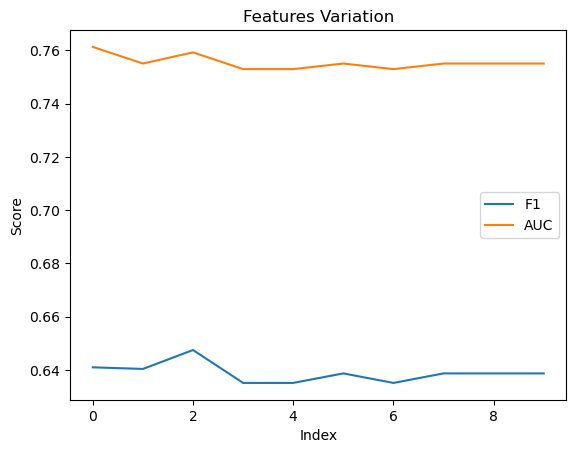

In [26]:
indices = range(len(f1))

# Plotando o gráfico
plt.plot(indices, f1, label='F1')
plt.plot(indices, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [27]:
# Export results
nome_arquivo = "lm_fv.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Polynomial Features

In [28]:
feature_names = ['fanin','fanout','wmc','loc','rq','vq','pq','lq','cq','icq']

features = np.arange(1, 11, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', GradientBoostingClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__n_estimators': [10, 100, 1000],
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__subsample': [0.5, 0.7, 1.0],
        'classifier__max_depth': [3, 7, 9],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

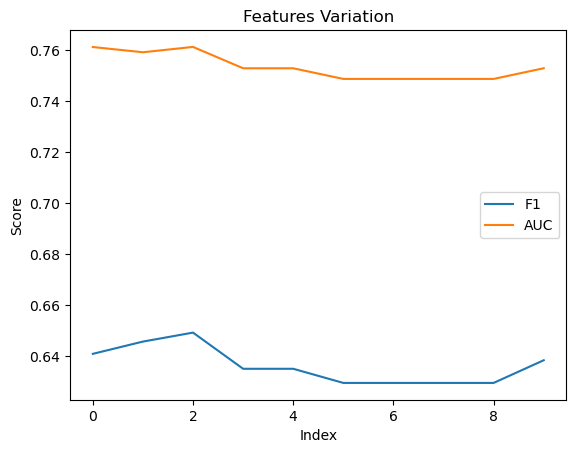

In [29]:
indices = range(len(f1))

# Plotando o gráfico
plt.plot(indices, f1, label='F1')
plt.plot(indices, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [30]:
# Export results
nome_arquivo = "lm_fv_poly.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Oversample variation

In [7]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        smote = SMOTE(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', GradientBoostingClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__n_estimators': [10, 100, 1000],
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__subsample': [0.5, 0.7, 1.0],
        'classifier__max_depth': [3, 7, 9],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

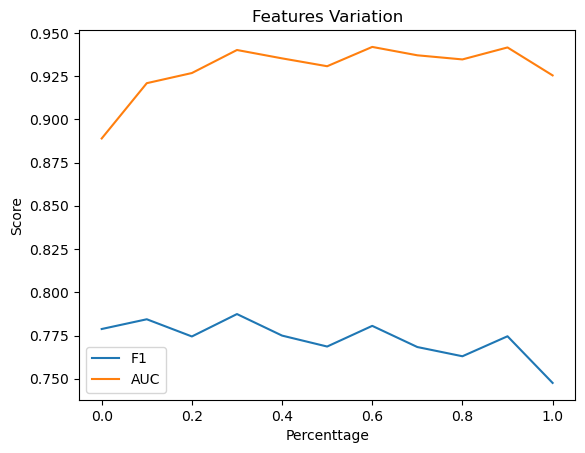

In [8]:
# Plotando o gráfico
plt.plot(percentage_samples, f1, label='F1')
plt.plot(percentage_samples, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Percenttage')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [9]:
# Export results
nome_arquivo = "lm_oversample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

### Undersample Variation

In [10]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        undersample = RandomUnderSampler(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = undersample.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=2)),
        ('classifier', GradientBoostingClassifier(random_state=SEED))
    ])
    
    hyperparameters ={
        'classifier__n_estimators': [10, 100, 1000],
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__subsample': [0.5, 0.7, 1.0],
        'classifier__max_depth': [3, 7, 9],
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\feature_selectio

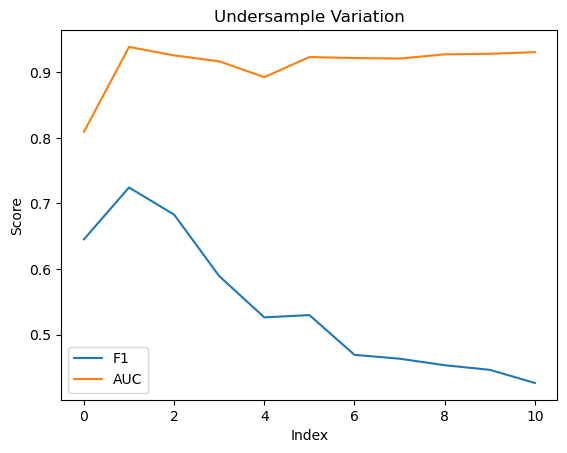

In [11]:
indices = range(len(f1))

# Plotando o gráfico
plt.plot(indices, f1, label='F1')
plt.plot(indices, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Undersample Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [12]:
# Export results
nome_arquivo = "lm_undersample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

## Feature Envy Evaluation

In [3]:
data = pd.read_csv('fe.csv')
data.dropna(inplace=True)
data.head()

,fanin,fanout,wmc,loc,rq,vq,pq,lq,cq,icq,fe
0,0,1,1,3,0,0,1,0,0,0,0
1,0,1,1,3,0,0,1,0,0,0,0
2,0,1,1,3,0,0,1,0,0,0,0
3,0,1,2,8,0,0,1,0,0,0,0
4,0,0,1,3,1,0,0,0,0,0,0


In [4]:
X = data.drop(['fe'], axis=1)
y = data.fe

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

#### Only original features

In [16]:
feature_names = ['fanin','fanout','wmc','loc','rq','vq','pq','lq','cq','icq']

features = np.arange(1, 11, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ])
    
    hyperparameters = {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

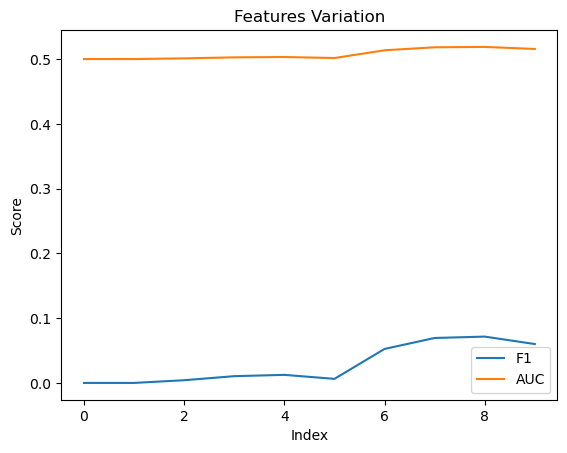

In [17]:
indices = range(len(f1))

# Plotando o gráfico
plt.plot(indices, f1, label='F1')
plt.plot(indices, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [19]:
features_set = []
for i, features in enumerate(selected_features):
    features_set.append('|'.join(features))

In [20]:
# Export results
nome_arquivo = "fe_fv.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Polynomial Features

In [21]:
feature_names = ['fanin','fanout','wmc','loc','rq','vq','pq','lq','cq','icq']

features = np.arange(1, 11, 1)

f1 = []
auc = []
selected_features = []

for num_features in features:
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=num_features)),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ])
    
    hyperparameters = {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    
    selected = best_model.named_steps['feature_selection'].get_support()
    
    selected_feature_names = np.array(feature_names)[selected]
    
    selected_features.append(selected_feature_names)
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

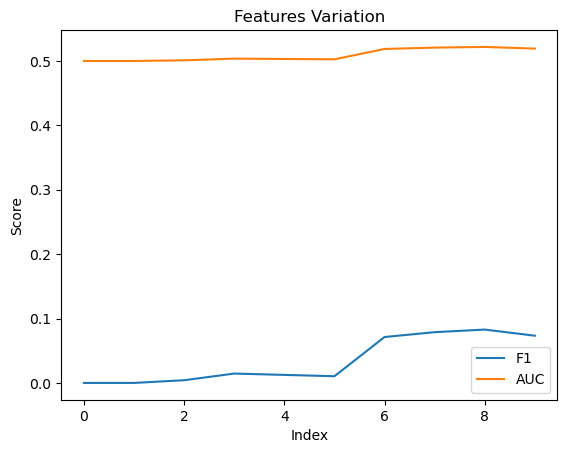

In [22]:
indices = range(len(f1))

# Plotando o gráfico
plt.plot(indices, f1, label='F1')
plt.plot(indices, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [23]:
features_set = []
for i, features in enumerate(selected_features):
    features_set.append('|'.join(features))

In [24]:
# Export results
nome_arquivo = "fe_fv_poly.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["features", "f1", "auc", "set"])

    for i in range(len(features)):
        writer.writerow([features[i], f1[i], auc[i], features_set[i]])

#### Oversample variation

In [25]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        smote = SMOTE(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ])
    
    hyperparameters = {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

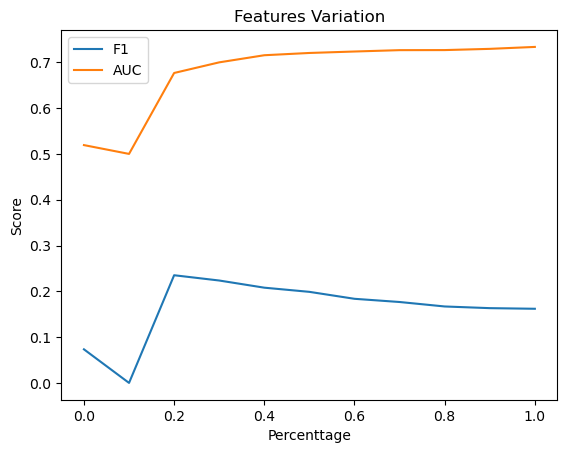

In [26]:
# Plotando o gráfico
plt.plot(percentage_samples, f1, label='F1')
plt.plot(percentage_samples, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Percenttage')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [27]:
# Export results
nome_arquivo = "fe_oversample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])

#### Undersample variation

In [6]:
percentage_samples = np.arange(0.0, 1.1, 0.1)

f1 = []
auc = []

for percentage in percentage_samples:
    
    if percentage == 0.0:
        X_train_oversampled = X_train
        y_train_oversampled = y_train
    else:
        undersample = RandomUnderSampler(sampling_strategy=percentage, random_state=SEED)
        X_train_oversampled, y_train_oversampled = undersample.fit_resample(X_train, y_train)
    
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ])
    
    hyperparameters = {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    }
    
    randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions=hyperparameters,
                                       cv=KFold(n_splits=10),
                                       random_state=SEED)
    
    randomized_search.fit(X_train_oversampled, y_train_oversampled)
    
    best_model = randomized_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred))
    
    auc.append(roc_auc_score(y_test, y_pred))

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

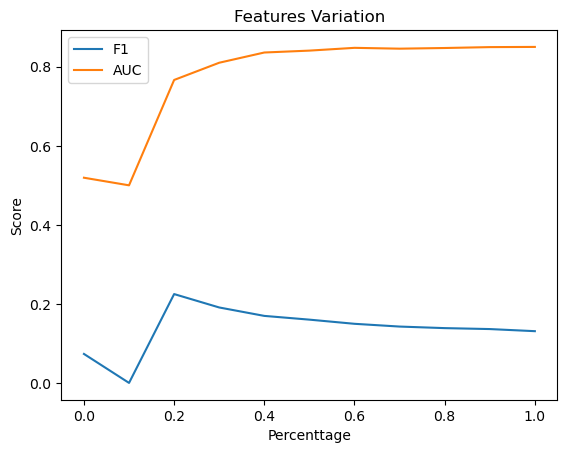

In [7]:
# Plotando o gráfico
plt.plot(percentage_samples, f1, label='F1')
plt.plot(percentage_samples, auc, label='AUC')

# Configurações adicionais do gráfico
plt.xlabel('Percenttage')
plt.ylabel('Score')
plt.title('Features Variation')
plt.legend()

# Exibindo o gráfico
plt.show()

In [8]:
# Export results
nome_arquivo = "fe_undersample.csv"

with open(nome_arquivo, "w", newline="") as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    writer.writerow(["percentage", "f1", "auc"])

    for i in range(len(percentage_samples)):
        writer.writerow([percentage_samples[i], f1[i], auc[i]])